In [1]:
import os, glob, scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout #Dense 층을 만들기위함(많이쓸듯)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #좋은 모델 기억
from tensorflow.keras.models import load_model# 모델 불러오기
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


#사진 흑백으로 저장 필요할 시

path = "./data_(1)/Free(1)/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/Free(1)/" + str(count) + ".jpg" , gray)
print("All Done")


#사진 흑백으로 저장 필요할 시

path = "./data_(1)/Full(1)/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/Full(1)/" + str(count) + ".jpg" , gray)
print("All Done")

#사진 흑백으로 저장 필요할 시

path = "./data_(1)/test/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/test/" + str(count) + ".jpg" , gray)
print("All Done")

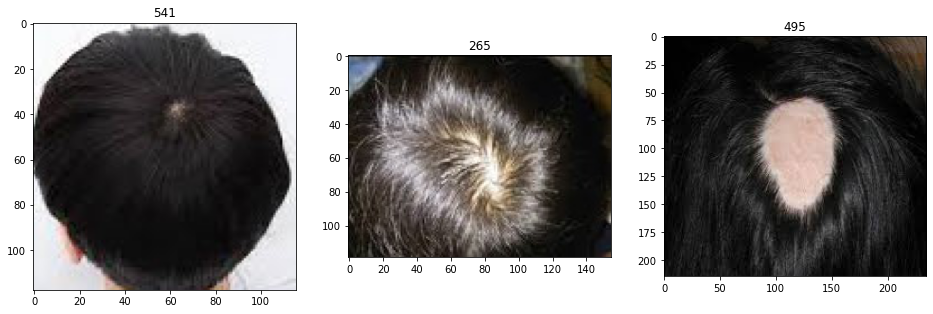

In [2]:
#데이터 불러오기

BASE_PATH = 'data(원형)'

full_list = glob.glob(os.path.join(BASE_PATH, '양호/*.jpg'))
middle_list = glob.glob(os.path.join(BASE_PATH, '주의/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, '경계/*.jpg'))



full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
middle_img = img_to_array(load_img(middle_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)


plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 3, 2)
plt.title(len(middle_list))
plt.imshow(middle_img)
plt.subplot(1, 3, 3)
plt.title(len(free_list))
plt.imshow(free_img)


# DataGenerator

In [3]:
#데이터 라벨링

#90% 학습용 10% 검증용

#preprocess_input (이미지 정규화)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)
#데이터 불러온 후 resize
#라벨링

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['양호','주의','경계'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['양호','주의','경계'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)
print(train_gen.class_indices)
print(val_gen.class_indices)

Found 1172 images belonging to 3 classes.
Found 129 images belonging to 3 classes.
{'양호': 0, '주의': 1, '경계': 2}
{'양호': 0, '주의': 1, '경계': 2}


In [10]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [11]:
for layer in model.layers:
    layer.trainable = True

In [12]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 0.1657 - acc: 0.9317
Epoch 00001: val_acc improved from -inf to 0.58140, saving model to model.h5
37/37 [==============================] - 24s 645ms/step - loss: 0.1657 - acc: 0.9317 - val_loss: 11.5041 - val_acc: 0.5814
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.0706 - acc: 0.9855
Epoch 00002: val_acc did not improve from 0.58140
37/37 [==============================] - 17s 464ms/step - loss: 0.0706 - acc: 0.9855 - val_loss: 11.1937 - val_acc: 0.5426
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.0957 - acc: 0.9727
Epoch 00003: val_acc did not improve from 0.58140
37/37 [==============================] - 17s 462ms/step - loss: 0.0957 - acc: 0.9727 - val_loss: 21.6990 - val_acc: 0.4419
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 0.0353 - acc: 0.9855
Epoch 00004: val_acc did not improve from 0.58140
37/37 [==============================] - 17s 452

Epoch 32/50
37/37 [==============================] - ETA: 0s - loss: 0.0124 - acc: 0.9966
Epoch 00032: val_acc did not improve from 0.73643
37/37 [==============================] - 17s 461ms/step - loss: 0.0124 - acc: 0.9966 - val_loss: 30.7741 - val_acc: 0.3798
Epoch 33/50
37/37 [==============================] - ETA: 0s - loss: 0.0135 - acc: 0.9974
Epoch 00033: val_acc did not improve from 0.73643
37/37 [==============================] - 17s 459ms/step - loss: 0.0135 - acc: 0.9974 - val_loss: 25.2886 - val_acc: 0.3798
Epoch 34/50
37/37 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 00034: val_acc did not improve from 0.73643
37/37 [==============================] - 17s 472ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 23.6067 - val_acc: 0.3798
Epoch 35/50
37/37 [==============================] - ETA: 0s - loss: 9.7549e-04 - acc: 1.0000
Epoch 00035: val_acc did not improve from 0.73643
37/37 [==============================] - 17s 455ms/step - loss: 9.7

In [13]:
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] 
   
new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, 
        model.layers[-1].output
    )
)

new_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [19]:
path_dir = 'C:/Users/dz3kz/project(원형 탈모)/test'
 
file_list = os.listdir(path_dir)
print(file_list)

['1.jpg', '워너비_128.jpg', '워너비_82.jpg', '워너비_83.jpg', '원형탈모_23.jpg', '원형탈모_25.jpg', '원형탈모_31.jpg', '원형탈모_519.jpg', '원형탈모_745.jpg', '원형탈모_748.jpg', '정수리탈모_182-1.jpg', '정수리탈모_182.jpg', '정수리탈모_47.jpg']


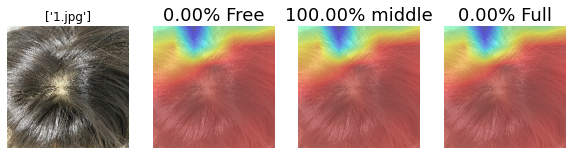

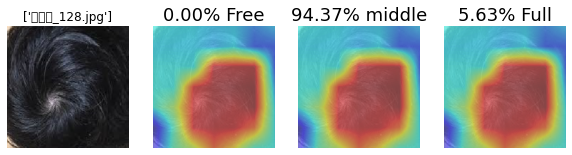

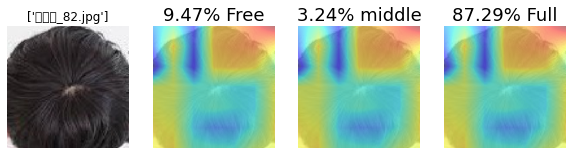

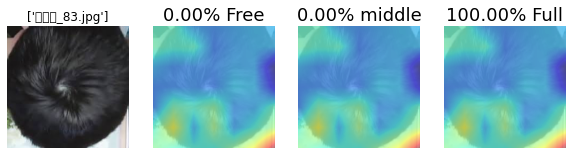

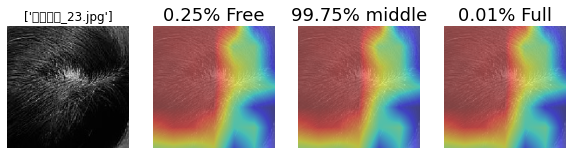

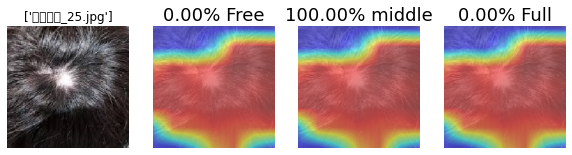

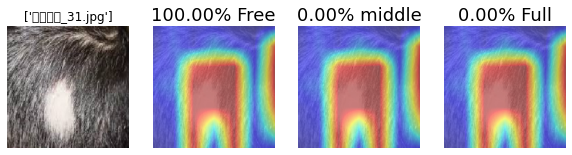

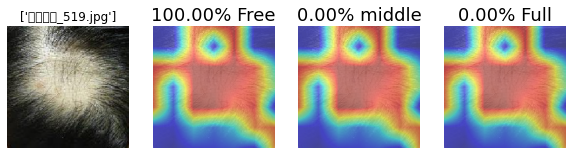

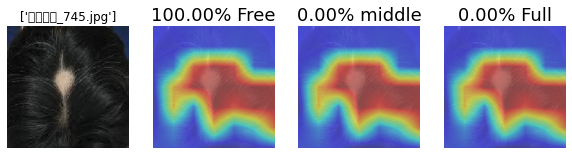

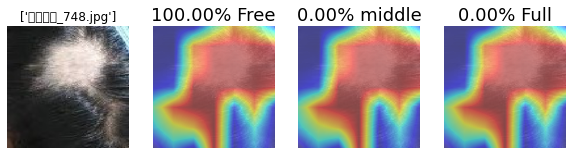

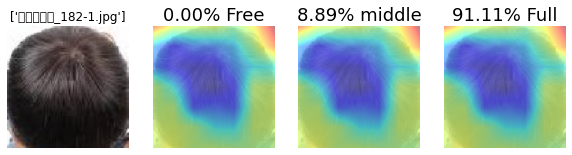

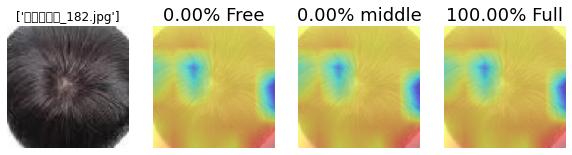

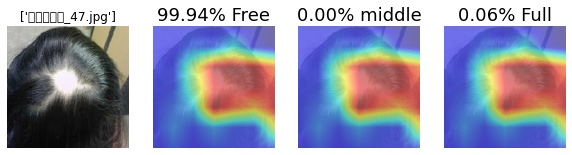

In [32]:
parking_list=file_list

for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(path_dir, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    
    
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=4)
    fig.set_size_inches(10,5)
   

    ax[0].imshow(test_img.astype(np.uint8))
    ax[0].set_title(parking.split(','))
    ax[0].axis('off')

    ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[1].imshow(final_output, cmap='jet', alpha=0.5)
    ax[1].set_title('%.2f%% Free' % (pred[0][2]*100),fontdict={'fontsize': 18, 'fontweight': 'medium'})
    ax[1].axis('off')
    
    
    ax[2].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[2].imshow(final_output, cmap='jet', alpha=0.5)
    ax[2].set_title('%.2f%% middle' % (pred[0][1]*100),fontdict={'fontsize': 18, 'fontweight': 'medium'})
    ax[2].axis('off')
    
    
    ax[3].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[3].imshow(final_output, cmap='jet', alpha=0.5)
    ax[3].set_title('%.2f%% Full' % (pred[0][0]*100),fontdict={'fontsize': 18, 'fontweight': 'medium'})
    ax[3].axis('off')
    
    
  
    
    plt.show()